In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score




In [125]:
hpi_df = pd.read_excel('./datasets/untidied/housing_price_index.xlsx', header=None)
northland_data = pd.read_csv('./datasets/Northland.csv')

In [126]:
northland_data.head()

Unnamed: 0        date      Northland         lagged
0           0  1992-01-31   95459.286676            NaN
1           1  1992-02-29  100422.274563   95459.286676
2           2  1992-03-31   93474.091521  100422.274563
3           3  1992-04-30   98437.079408   93474.091521
4           4  1992-05-31   93474.091521   98437.079408

In [127]:
hpi_df.head()

0                1                        2  \
0        NaN      House sales  House price index (HPI)   
1        NaN         (Number)                  (Index)   
2      Notes              NaN                      NaN   
3       Unit               no                    Index   
4  Series Id  QVB.Q.MR0H01.na           HPI.Q.H01T0.ia   

                              3                             4  
0  Total value of housing stock  Residential investment (GDP)  
1                          ($m)                     (Real $m)  
2                           Yes                           NaN  
3                          NZDm                       NZDm(r)  
4                      HHAL.QC1                 GDE.Q.EI24.RA

In [128]:
northland_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  392 non-null    int64  
 1   date        392 non-null    object 
 2   Northland   392 non-null    float64
 3   lagged      391 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 12.4+ KB


In [129]:
northland_data.describe()

Unnamed: 0      Northland         lagged
count  392.000000     392.000000     391.000000
mean   195.500000  309297.241516  308475.829395
std    113.304898  184276.811379  183792.946756
min      0.000000   90000.000000   90000.000000
25%     97.750000  155015.141319  155015.141319
50%    195.500000  293978.802153  293978.802153
75%    293.250000  363460.632571  363460.632571
max    391.000000  827500.000000  827500.000000

In [130]:
northland_data.dtypes

Unnamed: 0      int64
date           object
Northland     float64
lagged        float64
dtype: object

In [131]:
northland_data.isnull().sum()

Unnamed: 0    0
date          0
Northland     0
lagged        1
dtype: int64

In [132]:
northland_data = northland_data.drop(columns=['Unnamed: 0'])

In [133]:
hpi_new = hpi_df.iloc[5:, [0, 1, 2, 3, 4]]
hpi_new.columns = ["date", "house_sales", "house_price_index", "total_value_housing_stock", "residential_investment_gdp"]

In [134]:
# Convert the 'date' column to datetime
hpi_new['date'] = pd.to_datetime(hpi_new['date'], errors='coerce')

In [135]:
hpi_clean = hpi_new.dropna(subset=['date'])

In [136]:
# Convert columns to numeric
hpi_clean[['house_sales', 'house_price_index', 'total_value_housing_stock', 'residential_investment_gdp']] = hpi_clean[
    ['house_sales', 'house_price_index', 'total_value_housing_stock', 'residential_investment_gdp']].apply(pd.to_numeric, errors='coerce')

In [137]:
northland_data['date'] = pd.to_datetime(northland_data['date'], errors='coerce')

In [138]:
northland_data = northland_data.dropna(subset=['date'])

In [139]:
# Merge 
northland_final = pd.merge(northland_data, hpi_clean, on='date', how='inner')

In [140]:
northland_final.tail()

date      Northland         lagged  house_sales  house_price_index  \
125 2023-06-30  691017.833109  715832.772544      18602.0             3349.0   
126 2023-09-30  700943.808883  671165.881561      18589.0             3404.0   
127 2023-12-31  631461.978466  676128.869448      19975.0             3464.0   
128 2024-03-31  700943.808883  750573.687752      18603.0             3467.0   
129 2024-06-30  631461.978466  641387.954240          NaN                NaN   

     total_value_housing_stock  residential_investment_gdp  
125                  1563341.0                        4016  
126                  1590955.0                        4138  
127                  1621444.0                        4034  
128                  1630738.0                        3677  
129                        NaN                        3785

Text(0.5, 1.0, 'Distribution of House Prices in Northland')

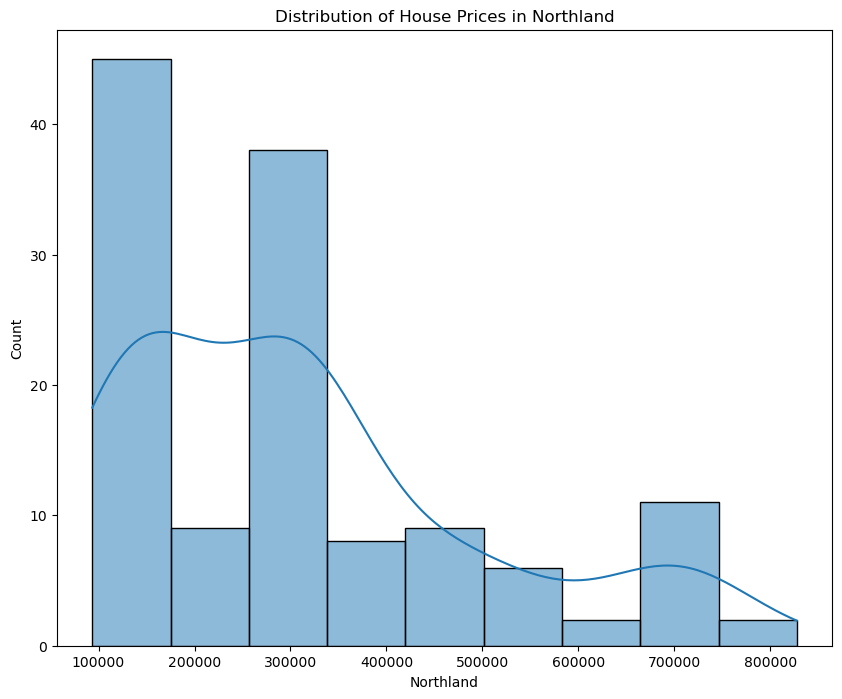

In [141]:
#Quick Plot
plt.figure(figsize=(10, 8))
sns.histplot(northland_final['Northland'], kde=True)
plt.title('Distribution of House Prices in Northland')

In [142]:
#export to csv
northland_final.to_csv('northland final data.csv', index=True)

In [143]:
northland_final.head()


date      Northland         lagged  house_sales  house_price_index  \
0 1992-03-31   93474.091521  100422.274563      18659.0              468.0   
1 1992-06-30   93474.091521   93474.091521      18560.0              467.0   
2 1992-09-30   93474.091521   97940.780619      18946.0              470.0   
3 1992-12-31  111340.847914   93474.091521      18646.0              477.0   
4 1993-03-31   96451.884253  100422.274563      19960.0              481.0   

   total_value_housing_stock  residential_investment_gdp  
0                   125000.0                        1498  
1                   127000.0                        1701  
2                   128000.0                        1576  
3                   129000.0                        1757  
4                   131000.0                        1555

In [144]:
# Preprocessing and feature engineering
northland_final['date'] = pd.to_datetime(northland_final['date'])

# fill Na's
northland_final.fillna(northland_final.mean(), inplace=True)

# Split date
northland_final['year'] = northland_final['date'].dt.year
northland_final['quarter'] = northland_final['date'].dt.quarter
northland_final['month'] = northland_final['date'].dt.month
northland_final['day_of_week'] = northland_final['date'].dt.dayofweek

In [156]:
northland_final

date      Northland         lagged   house_sales  house_price_index  \
0   1992-03-31   93474.091521  100422.274563  18659.000000         468.000000   
1   1992-06-30   93474.091521   93474.091521  18560.000000         467.000000   
2   1992-09-30   93474.091521   97940.780619  18946.000000         470.000000   
3   1992-12-31  111340.847914   93474.091521  18646.000000         477.000000   
4   1993-03-31   96451.884253  100422.274563  19960.000000         481.000000   
..         ...            ...            ...           ...                ...   
125 2023-06-30  691017.833109  715832.772544  18602.000000        3349.000000   
126 2023-09-30  700943.808883  671165.881561  18589.000000        3404.000000   
127 2023-12-31  631461.978466  676128.869448  19975.000000        3464.000000   
128 2024-03-31  700943.808883  750573.687752  18603.000000        3467.000000   
129 2024-06-30  631461.978466  641387.954240  24881.488372        1550.085271   

     total_value_housing_stock  residential_investment_gdp  year  quarter  \
0                 1.250000e+05                        1498  1992        1   
1                 1.270000e+05                        1701  1992        2   
2                 1.280000e+05                        1576  1992        3   
3                 1.290000e+05                        1757  1992        4   
4                 1.310000e+05                        1555  1993        1   
..                         ...                         ...   ...      ...   
125               1.563341e+06                        4016  2023        2   
126               1.590955e+06                        4138  2023        3   
127               1.621444e+06                        4034  2023        4   
128               1.630738e+06                        3677  2024        1   
129               6.412787e+05                        3785  2024        2   

     month  day_of_week  
0        3            1  
1        6            1  
2        9            2  
3       12            3  
4        3            2  
..     ...          ...  
125      6            4  
126      9            5  
127     12            6  
128      3            6  
129      6            6  

[130 rows x 11 columns]

In [147]:
features = ['lagged', 'house_sales', 'house_price_index', 'total_value_housing_stock', 'residential_investment_gdp',
            'year', 'month', 'day_of_week','quarter']

X = northland_final[features]
y = northland_final['Northland']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [150]:
# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [151]:
# Set LightGB Model
lgb_model = lgb.LGBMRegressor(random_state=42)

In [152]:
#baseline model
lgb_model.fit(X_train_scaled, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 224
[LightGBM] [Info] Number of data points in the train set: 104, number of used features: 9
[LightGBM] [Info] Start training from score 312475.478215
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

LGBMRegressor(random_state=42)

In [153]:
#predict on X_test
y_pred = lgb_model.predict(X_test_scaled)

In [158]:
from sklearn.metrics import mean_squared_error
# Evaluate metrics
lgb_mse = mean_squared_error(y_test, y_pred)
lgb_rmse = np.sqrt(lgb_mse)
lgb_mae = mean_absolute_error(y_test, y_pred)
lgb_r2 = r2_score(y_test, y_pred)

print("Baseline results:")
print(f"MSE: {lgb_mse}")
print(f"RMSE: {lgb_rmse}")
print(f"MAE: {lgb_mae}")
print(f"R²: {lgb_r2}")


Baseline results:
MSE: 2297667824.3187237
RMSE: 47933.994454027335
MAE: 30047.49953313874
R²: 0.9359677760093233


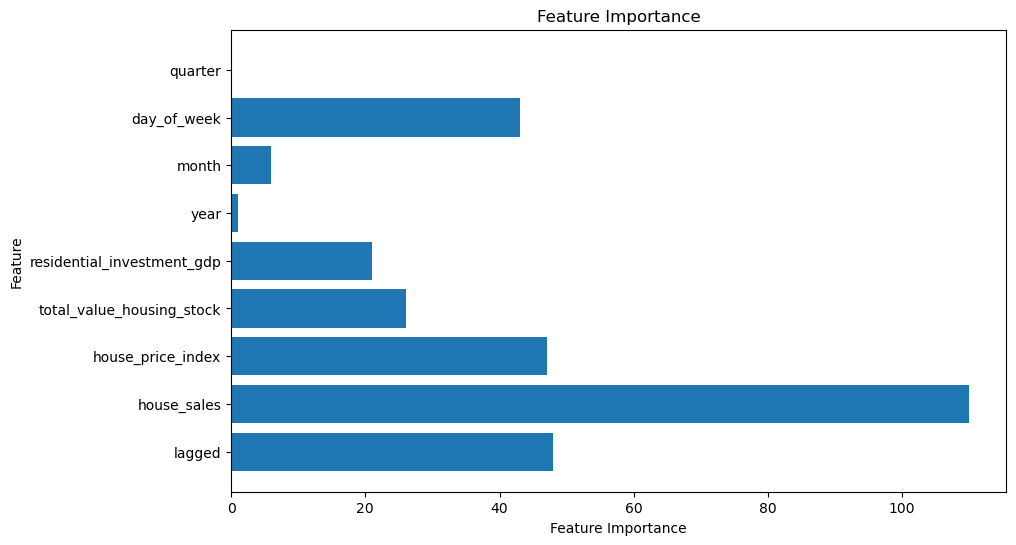

In [161]:
#feature importance
feature_importances = lgb_model.feature_importances_
features = X.columns

plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()



Interpretation

We can see from the plot above that the most important features or the features that are contributing the most towards predicting house prices in the Northland area. Lagged and House_price_index also have a moderate effect on house prices predictions as well. Some features such as the year, month and quarter have much less effect or no effect and so will most likley be dropped in during the re-train/tune.

In [163]:
new_selected_features = ['house_sales', 'lagged', 'total_value_housing_stock', 'residential_investment_gdp']

X_new_selected_features = northland_final[new_selected_features]
y = northland_final['Northland']

X_train_new, X_test_new, y_train, y_test = train_test_split(X_new_selected_features, y, test_size=0.2, random_state=42)

In [164]:
X_train_scaled_new = scaler.fit_transform(X_train_new)
X_test_scaled_new = scaler.transform(X_test_new)

In [165]:
# hyperparameter tuning
param = {
    'num_leaves': [30, 50, 70],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [-1, 10, 20],
}

grid_search = GridSearchCV(estimator=lgb.LGBMRegressor(random_state=42), 
                                    param_grid=param, 
                                    scoring='neg_mean_squared_error', 
                                    cv=5, 
                                    verbose=1, 
                                    n_jobs=-1)

grid_search.fit(X_train_scaled_new, y_train)

best_params = grid_search.best_params_

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 116
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 4
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 4
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 115
[LightGBM] [Info] Start training from score 320

In [167]:
lgb_model_tuned = grid_search.best_estimator_

In [168]:
y_pred_tuned = lgb_model_tuned.predict(X_test_scaled_new)

In [169]:
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
rmse_tuned = np.sqrt(mse_tuned)
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
r2_tuned = r2_score(y_test, y_pred_tuned)

print(f"MSE: {mse_tuned}")
print(f"RMSE: {rmse_tuned}")
print(f"MAE: {mae_tuned}")
print(f"R²: {r2_tuned}")

MSE: 1697880445.6978085
RMSE: 41205.344868084874
MAE: 26092.352907902336
R²: 0.9526828639642251
